# Laboratorio 1
## Microestructuras y Sistemas de Trading
### Pablo Mendoza

El presente laboratorio tiene como objetivo analizar el comportamiento de un ETF de acuerdo a la conformación de este y al movimiento de los precios que se presentaron entre el primero de Abril del 2017 hasta el 27 de Marzo del 2018 con el fin de identificar que tan conveniente es para un inversionista rebalancear el portafolio mensualmente o si por el contrario se debería cambiar la ponderación y los activos que este contiene de manera anual o al menos una vez al año. Para lograr este objetivo, se realizan diferentes medidas de desempeño que permitan comparar los portafolios resultantes.

## Primera Parte: Rebalanceos Mensuales

In [1]:
# Librerias
import quandl
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
fechas = list(['2017-03-28','2017-04-28','2017-05-31','2017-06-30','2017-07-31','2017-08-31','2017-09-29','2017-10-31','2017-11-30','2017-12-29','2018-01-31','2018-02-28','2018-03-27'])

In [3]:
# Funcion que descargue los precios de QuandL
def Download_QuandL(fechas:'Dates_list ', num_archivos:'number of archives'):
    d2 = {} # Crea un Diccionario Vacío
    for i in range(num_archivos): # cilco que descarga los datos de Quandl y los guarda como DataFrames en un Diccionario
        nom = "Data_"+str(i+1)
        tickerr = list(d[nom]["Ticker"])
        date = { 'gte': fechas[i], 'lte': fechas[i] }
        column = { 'columns': ['ticker', 'date', 'Adj_close']}
        data = quandl.get_table('WIKI/PRICES', qopts = column, ticker = tickerr, date = date, paginate=True)# ticker = 'WIKI/AAPL' #'AAPL.US'
        d2["Data_{0}".format(i+1)] = data.set_index('ticker')
        d[nom] = d[nom].set_index('Ticker') #El indice es el Ticker
    return d2
# Función qu eguarde los exceles en un diccionario y que los limpie
def Download_Excel_csv(num_archivos:'Number of documents', dir_:'Directory', f_name:'File name prefix' ):
    d = {} # Crea un Diccionario Vacío
    for i in range(num_archivos): # cilco que importa los CSV y los guarda como DataFrames en un Diccionario
        nom_arch = f_name+str(i+1)+".csv"    
        dir_f = dir_+nom_arch
        data = pd.read_csv(dir_f, skiprows = [0,1,2,3,4,5,6,7,8,9])
        d["Data_{0}".format(i+1)] = data#.set_index('Ticker')
    return d
# Funcion que elimina datos que no coinciden de Quandl y iShares
def Clean_Data(num_archivos:'', d:'Dictionary of Excel', d2:'Dictionary of QuandL'):
    d3 = {} # Crea un Diccionario Vacío
    for i in range(num_archivos):
        nom = "Data_"+str(i+1)
        a = set(list(d[nom].index))
        b = set(list(d2[nom].index))
        c = list(a-b) #compara los que hay en el CSV y en Quandl y asi quitarlos
        data_1 = d[nom]
        data_2 = d2[nom]
        data_1 = data_1.drop(c, axis = 0) #elimina los activos que QuandL no tiene
        data_1 = data_1.drop(["Name","Asset Class", "Market Value", "Shares", "Notional Value", "Sector", "SEDOL", "ISIN", "Exchange"],1)
        data = data_1.join(data_2)
        data = data.drop("date", axis = 1)
        data.columns = (["Weight","Start", "End"])
        data['Start'] = data['Start'].str.replace(',', '')
        data['Weight'] = data['Weight']/100
        data['Start'] = pd.to_numeric(data['Start'])
        d3["Data_{0}".format(i+1)] = data
    return d3
def Shares(d:'Data Frame',Capital_Inicial:'Capital Inicial'):
    shares = pd.DataFrame(np.floor((d['Weight']*Capital_Inicial)/d['Start']), columns = ['Shares'])
    d = d.join(shares)
    return d
# Listas
def listas(a, b):
    lista_final = []
    for i in a:
        if (i not in lista_final) and (i in b):
            lista_final.append(i)
    return lista_final
# Funcion del Rebalanceo
def rebalanceo(d_1,d_2,costo,Cap_In,l_Cap,l_NAV, Sobrante):
    # Ver diferencias entre tickers
    a = list(set(list(d_1.index))-set(list(d_2.index))) # Los que se Venden
    b = list(set(list(d_2.index))-set(list(set(list(d_2.index))-set(list(d_1.index))))) # Los que permanece
    c = list(set(list(d_2.index))-set(list(d_1.index))) # Los que se compran
    #Vender acciones
    df_venta = d_1.drop(b,0)
    value = sum(df_venta.iloc[:,2]*df_venta.iloc[:,3])
    Sobrante += (value - costo*value)
    #Comprar acciones
    df_compra = d_2.drop(b,0)
    value = sum(df_compra.iloc[:,2]*df_compra.iloc[:,3])
    Sobrante -= (value + costo*value)
    #Rebalanceo de Posiciones
    y1 = d_1.drop(a,0) # Mismos activos d_1
    y2 = d_2.drop(c,0) # Mismos activos d_2
    y1 = y1.sort_index()
    y2 = y2.sort_index()
    Shares_c_v = np.floor(((y2['Weight']-y1['Weight'])*Cap_In)/y2['End'])
    # Cuando el valor en Shares_c_v es +, se compran acciones
    # Cuando el valor en Shares_c_v es -, se venden acciones
    value = (Shares_c_v*y2['End']).sum()
    Sobrante += (value - costo*value)
    # Resultados del Rebalanceo
    NAV = sum(d_1['End']*d_1['Shares'])/sum(d_1['Shares'])
    Cap_ = sum(d_2['End']*d_2['Shares']) + Sobrante
    l_NAV.append(NAV)
    l_Cap.append(Cap_)
    return l_Cap, l_NAV, Sobrante

In [4]:
num_ar = 13 #numero de archivoa a importar (Series + 1)
d = Download_Excel_csv(num_ar,"/Users/pablomendoza/Documents/ITESO/Trading/Lab_1/lab1_p1_eq4/Data/","IJH_holdings-" )
d2 = Download_QuandL(fechas,num_ar)
d3 = Clean_Data(num_ar, d, d2)              
Capital_Inicial = 100000000 # cien melones
Costo_Transaccion = 0.0003#se cobra el % de lo que se compra o vende
for i in range(num_ar):
    nom = "Data_"+str(i+1)
    d3["Data_{0}".format(i+1)] = Shares(d3[nom],Capital_Inicial) #de Data_1 a Data_13
d3['Data_1'].head() #d3 tiene en un Dataframe la informaciòn de cada inicio y fin de mes
l_Cap = list()
l_NAV = list()
ind = list(d3.keys())
S = Capital_Inicial - sum(d3['Data_1']['End']*d3['Data_1']['Shares']) #Sobrante inicial

In [5]:
for p in range(len(ind)-1):
    l_Cap, l_NAV, S = rebalanceo(d3[ind[p]], d3[ind[p+1]], Costo_Transaccion, Capital_Inicial, l_Cap, l_NAV, S)

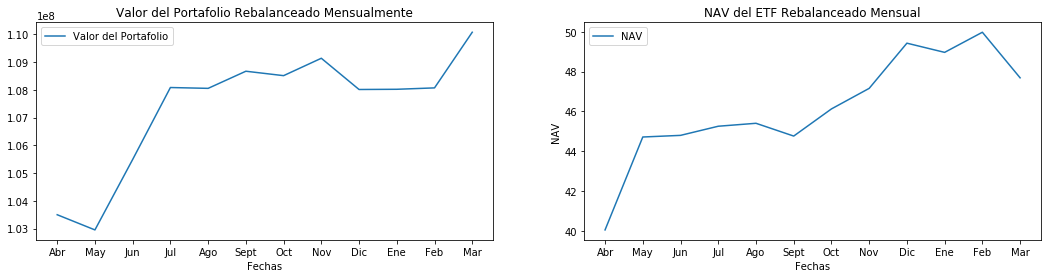

In [6]:
plt.figure(figsize = (18,4))
plt.subplot(121)
plt.plot(l_Cap, label = 'Valor del Portafolio')
plt.title('Valor del Portafolio Rebalanceado Mensualmente')
plt.xticks(np.arange(0,12,1), ('Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic','Ene','Feb','Mar'))
plt.xlabel('Fechas')
plt.ylabel('')
plt.legend()
plt.subplot(122)
plt.plot(l_NAV, label = 'NAV')
plt.title('NAV del ETF Rebalanceado Mensual')
plt.xticks(np.arange(0,12,1), ('Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic','Ene','Feb','Mar'))
plt.xlabel('Fechas')
plt.ylabel('NAV')
plt.legend()

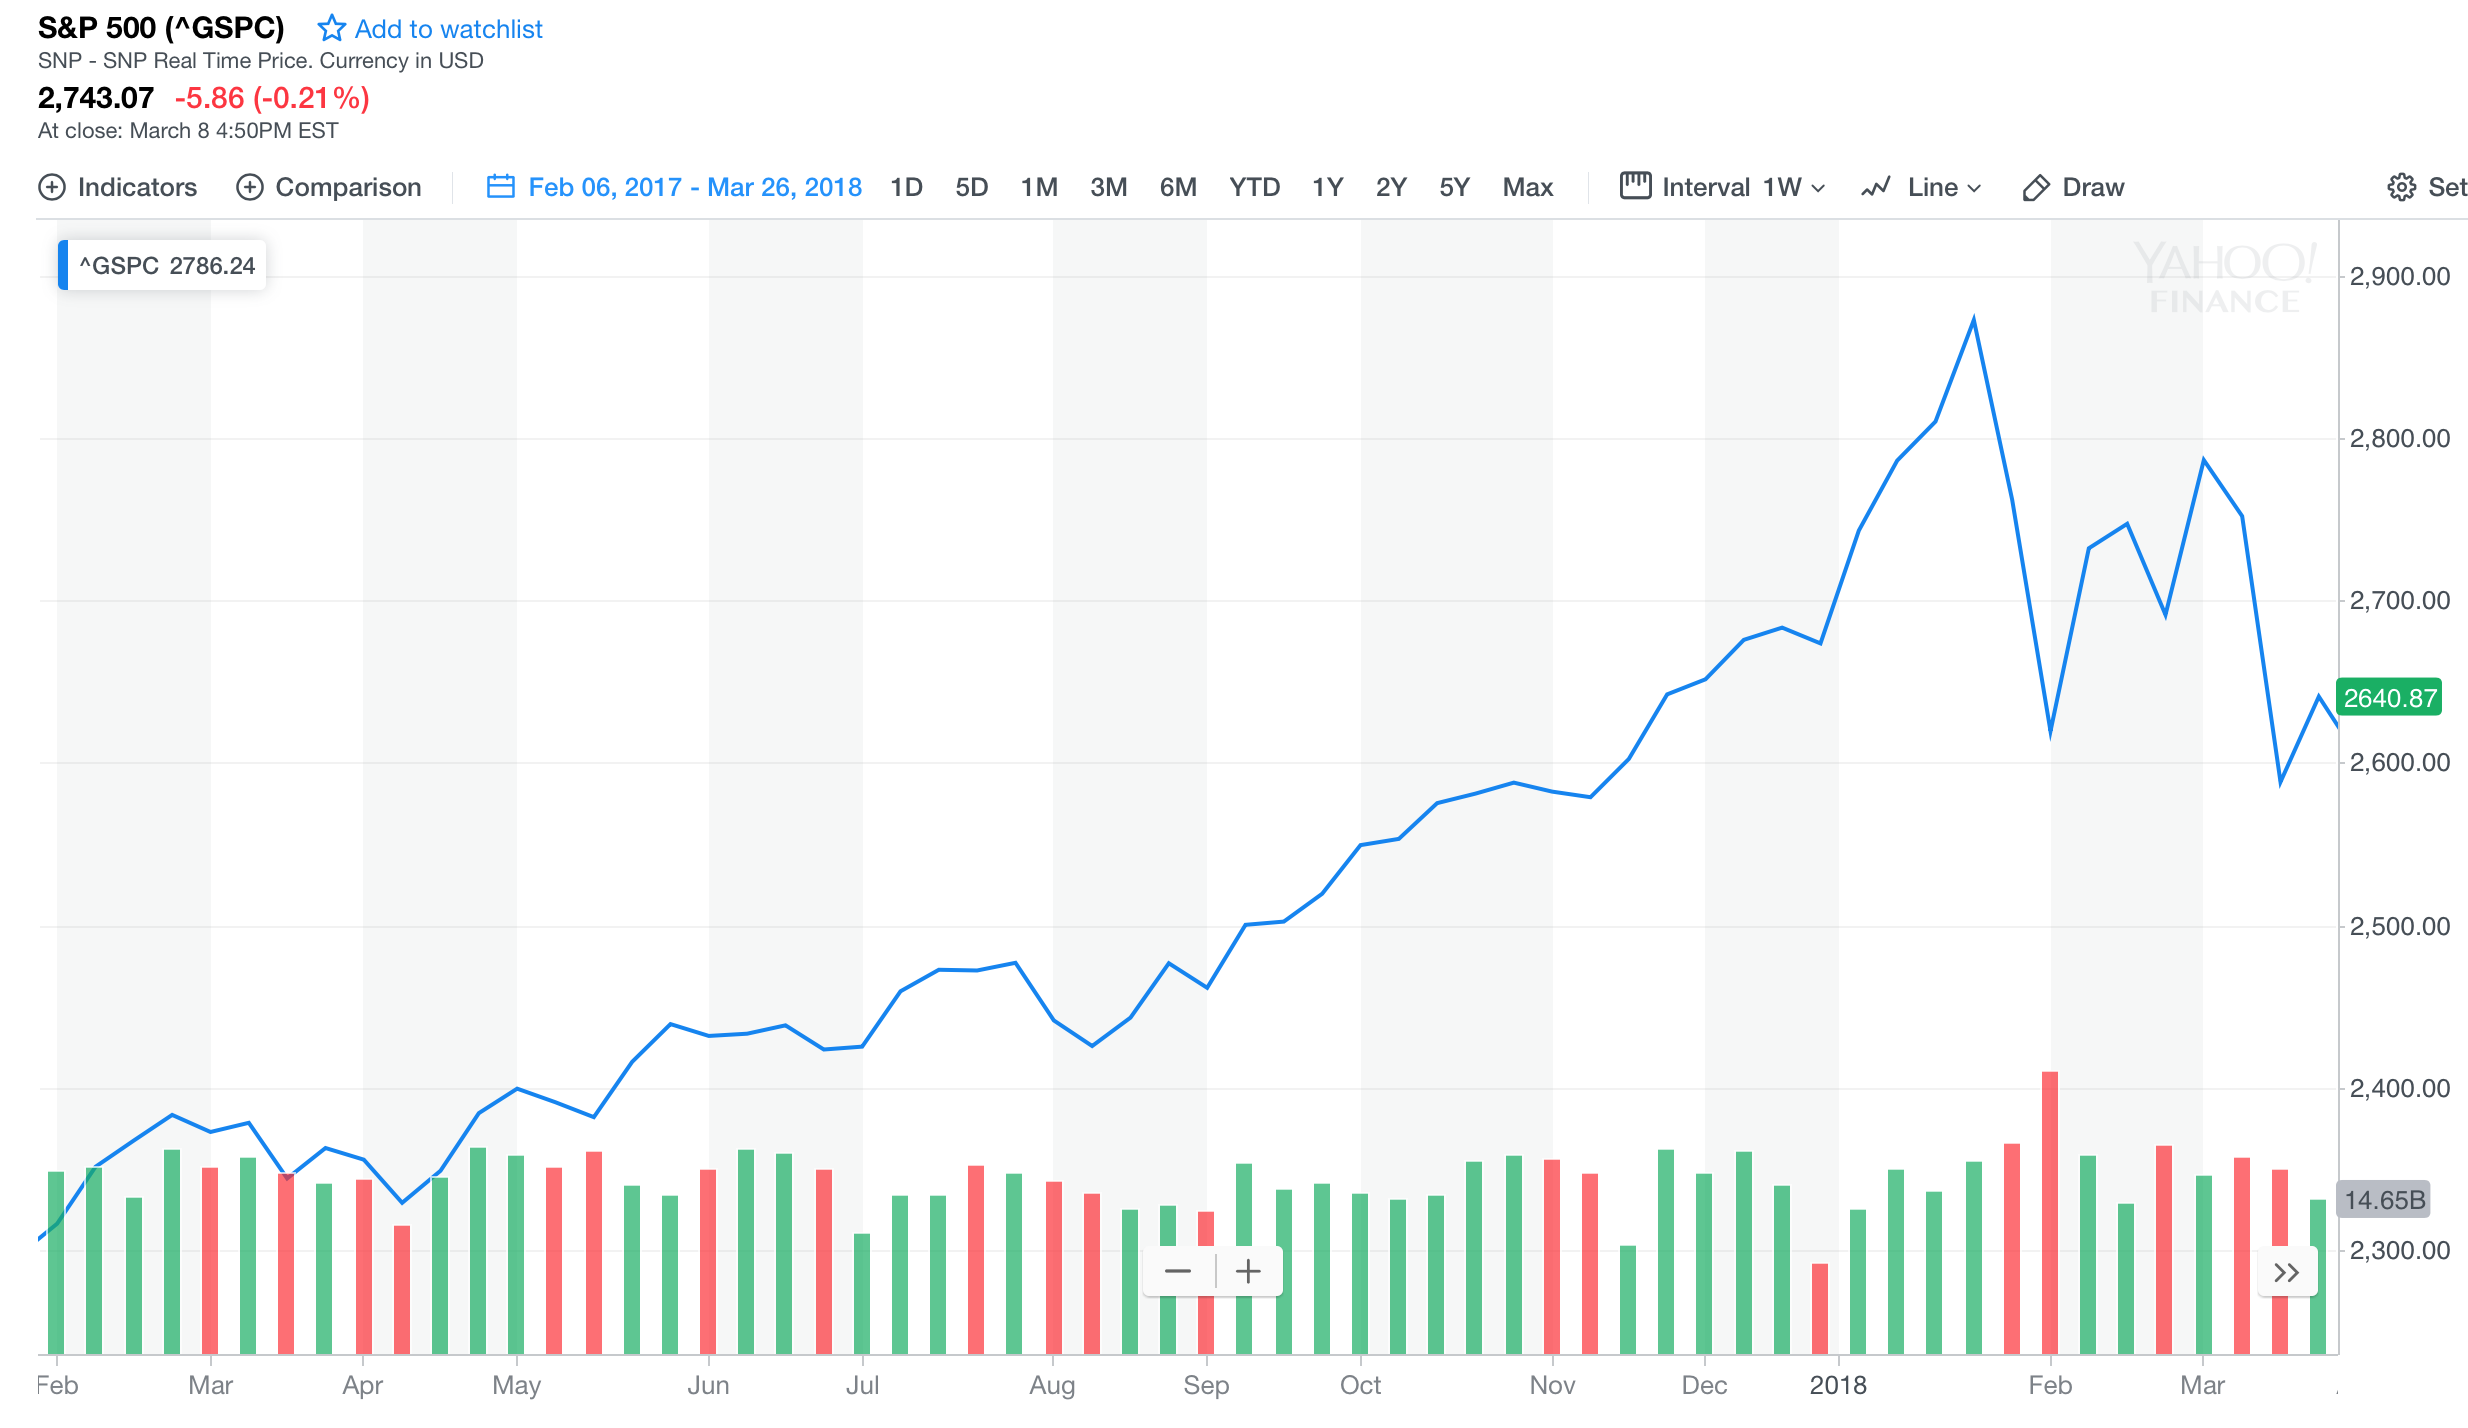

In [7]:
PATH = "/Users/pablomendoza/Documents/ITESO/Trading/Lab_1/lab1_p1_eq4/"
Image(filename = PATH + "picture.png", width=500, height=500)

In [8]:
Rend=((pd.DataFrame(l_Cap, columns =  ['Rendimiento %'])-100000000)/100000000)*100
Rend

,Rendimiento %
0,3.497381
1,2.949818
2,5.489058
3,8.082552
4,8.052264
5,8.669742
6,8.510358
7,9.137282
8,8.011381
9,8.018963


De forma comparativa, se puede observar que el valor del ETF, al igual que el Net Asset Value (NAV) del portafolio tienen un comportamiento similar al del S&P durante el periodo analizado. El crecimiento desde marzo 2017 hasta febrero de 2018 y la caida posterior a febrero de 2018 coinciden con el portafolio analizado. 

Para el periodo analizado del ETF del S&P de iShares se observa que se tuvo un buen desempeño a lo largo del año haciendo rebalanceos mensuales. El mayor valor del Portafolio se dió en el cuarto trimestre de 2017. Como una observación a la tendencia del Valor del Portafolio Rebalanceado Mensualmente, haciendo enfasis en el comportamiento horizontal en los meses de enero y febrero, se considera que la falta de crecimiento en el portafolio se debe a las bajas en el valor del S&P como se muestra en la imagen anterior.

## Segunda Parte: Rebalanceo Mes-Año

A continuación, se crean diferentes portafolios los cuales son rebalanceados una vez al año en diferentes meses en el periodo de tiempo anteriormente establecido. 

In [9]:
l_Cap_m = list()
l_NAV_m = list()
ind = list(d3.keys())
for p in range(len(ind)-1):
    S = Capital_Inicial - sum(d3[ind[p]]['End']*d3[ind[p]]['Shares']) #Sobrante inicial
    l_Cap_m, l_NAV_m, S = rebalanceo(d3[ind[p]], d3[ind[-1]], Costo_Transaccion, Capital_Inicial, l_Cap_m, l_NAV_m, S)

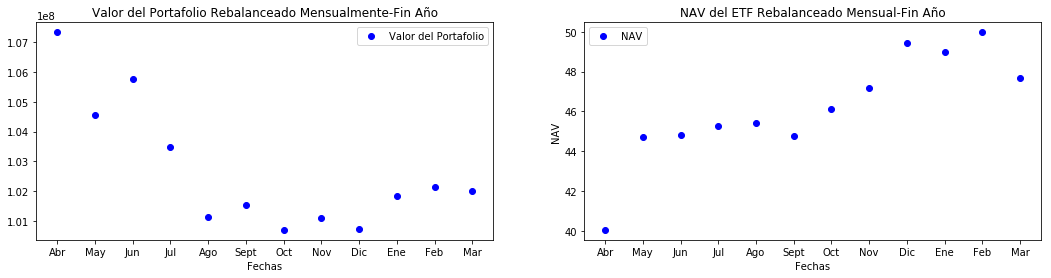

In [10]:
y = np.arange(12)
plt.figure(figsize = (18,4))
plt.subplot(121)
plt.plot(y, l_Cap_m, 'bo' , label = 'Valor del Portafolio')
plt.title('Valor del Portafolio Rebalanceado Mensualmente-Fin Año')
plt.xticks(np.arange(0,12,1), ('Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic','Ene','Feb','Mar'))
plt.xlabel('Fechas')
plt.ylabel('')
plt.legend()
plt.subplot(122)
plt.plot(y, l_NAV_m, 'bo', label = 'NAV')
plt.title('NAV del ETF Rebalanceado Mensual-Fin Año')
plt.xticks(np.arange(0,12,1), ('Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic','Ene','Feb','Mar'))
plt.xlabel('Fechas')
plt.ylabel('NAV')
plt.legend()

Las Gráficas anteriores hacen sentido, primero por que en la de Valor del Portafolio Rebalanceado Mensualmente-Fin Año, como durante el año el S&P tuvo un comportamiento alcista, entre más anterior sea el periodo de compra de los activos respecto al del fin del año considerando la tendencia se tiene una mejor pocisión. Por otra parte entre más cercano se esta al Fin de Año, menos ganancia se obtiene. A continuación se muestra una tabla con los Rendimientos Mes- fin de Año

In [11]:
Rend_m=((pd.DataFrame(l_Cap_m, columns =  ['Rendimiento %'])-100000000)/100000000)*100
Rend_m

,Rendimiento %
0,7.334319
1,4.556029
2,5.749060
3,3.494611
4,1.147990
5,1.527780
6,0.698362
7,1.108213
8,0.731383
9,1.828011


Segundo, como el S&P tuvo esa tendecia alcista, cada més el NAV del Portafolio aumentaba.

En términos generales se concluye de los resultados anteriores que para el periodo en mención hay poca diferencia entre los rebalanceos mensuales y los de mes-Año, sin embargo fue ligeramente superiror la ganancia con los rebalanceos mensuales.

## Tercera Parte: Métricas de Desempeño

In [12]:
# Importa los datos de Excel y los guarda en un diccionario llamado "d"
d = {} # Crea un Diccionario Vacío
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH" # Quandl API key
num_archivos = 12
etf = pd.read_csv('/Users/pablomendoza/Documents/ITESO/Trading/Lab_1/Trading/Data/iShares-Core-SP-Mid-Cap-ETF_fund.csv')
etf['Shares Outstanding'] = etf['Shares Outstanding'].str.replace(',', '')
etf['Index Level'] = etf['Index Level'].str.replace(',', '')
usd_rate = [0.0241,0.0241,0.0239,0.0240,0.0241,0.0241,0.0243,0.0243,0.0242,0.0242,0.0241, 0.0241]
nav_etf = etf['NAV per Share'].iloc[::-1].reset_index()
sp = etf['Index Level'].iloc[::-1].reset_index()
nav_etf = list(nav_etf['NAV per Share'].astype('float64'))
sp = list(sp['Index Level'].astype('float64'))

In [13]:
series = ['Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic','Ene','Feb','Mar']
rend = np.array(Rend)
riesgo = [np.std(etf['NAV per Share'][0:20]),np.std(etf['NAV per Share'][20:41]),np.std(etf['NAV per Share'][41:61]),np.std(etf['NAV per Share'][61:82]),np.std(etf['NAV per Share'][82:103]),np.std(etf['NAV per Share'][103:124]),np.std(etf['NAV per Share'][124:144]),np.std(etf['NAV per Share'][144:165]),np.std(etf['NAV per Share'][165:186]),np.std(etf['NAV per Share'][186:207]),np.std(etf['NAV per Share'][207:227]),np.std(etf['NAV per Share'][227:247])]
sharpe = ((rend/100)-usd_rate)/riesgo
NAV = l_NAV_m
# Treynor
beta_etf = (np.cov(NAV,usd_rate))
sistema = np.std(usd_rate)
no_sistema = np.std(NAV)
beta_port = ((no_sistema/sistema)*beta_etf)[1][1]
treynor = (((rend/100)-usd_rate)/beta_port)/100
tabla = pd.DataFrame(index=series,columns=['Rend %','Riesgo','Sharpe','Treynor %'])
tabla.index.name = "Mes-Año"
tabla['Rend %'] = rend
tabla['Riesgo'] = riesgo
tabla['Sharpe'] = sharpe
tabla['Treynor %'] = treynor
tabla

,Rend %,Riesgo,Sharpe,Treynor %
Mes-Año,,,,
Abr,3.497381,3.491464,0.003114,0.352253
May,2.949818,3.805464,0.001546,0.174872
Jun,5.489058,2.423678,0.008819,0.997449
Jul,8.082552,1.062565,0.016247,1.837601
Ago,8.052264,1.861316,0.016160,1.827789
Sept,8.669742,0.712489,0.017929,2.027819
Oct,8.510358,2.323581,0.017472,1.976187
Nov,9.137282,1.861911,0.019268,2.179277
Dic,8.011381,1.442182,0.016043,1.814545


In [14]:
series = ['Abr','May','Jun','Jul','Ago','Sept','Oct','Nov','Dic','Ene','Feb','Mar']
rend = np.array(Rend_m)
riesgo = [np.std(etf['NAV per Share'][0:20]),np.std(etf['NAV per Share'][20:41]),np.std(etf['NAV per Share'][41:61]),np.std(etf['NAV per Share'][61:82]),np.std(etf['NAV per Share'][82:103]),np.std(etf['NAV per Share'][103:124]),np.std(etf['NAV per Share'][124:144]),np.std(etf['NAV per Share'][144:165]),np.std(etf['NAV per Share'][165:186]),np.std(etf['NAV per Share'][186:207]),np.std(etf['NAV per Share'][207:227]),np.std(etf['NAV per Share'][227:247])]
sharpe = ((rend/100)-usd_rate)/riesgo
NAV = l_NAV
# Treynor
beta_etf = (np.cov(NAV,usd_rate))
sistema = np.std(usd_rate)
no_sistema = np.std(NAV)
beta_port = ((no_sistema/sistema)*beta_etf)[1][1]
treynor = (((rend/100)-usd_rate)/beta_port)/100
tabla = pd.DataFrame(index=series,columns=['Rend %','Riesgo','Sharpe','Treynor %'])
tabla.index.name = "Mensual"
tabla['Rend %'] = rend
tabla['Riesgo'] = riesgo
tabla['Sharpe'] = sharpe
tabla['Treynor %'] = treynor
tabla

,Rend %,Riesgo,Sharpe,Treynor %
Mensual,,,,
Abr,7.334319,3.491464,0.014104,1.595214
May,4.556029,3.805464,0.006147,0.695198
Jun,5.749060,2.423678,0.009563,1.081675
Jul,3.494611,1.062565,0.003106,0.351355
Ago,1.147990,1.861316,-0.003615,-0.408823
Sept,1.527780,0.712489,-0.002527,-0.285792
Oct,0.698362,2.323581,-0.004902,-0.554478
Nov,1.108213,1.861911,-0.003728,-0.421709
Dic,0.731383,1.442182,-0.004808,-0.543781


## Conclusión:

Como resultado del análisis de los rendimientos se puede evidenciar especialmente que, al principio del periodo de estudio, el rebalanceo mensual brindaba mejores rendimientos comparado con los rebalanceos una vez al año; sin embargo, a medida que avanzaba el tiempo este va generando menos rentabilidad con los otros portafolios. Por lo que fue una buena estrategia en los primeros meses y aunque en los últimos meses no fue tan eficiente. En la última tabla se observa por el índice de Sharpe y Treynor que no hay una buena rentabilidad por el riesgo que se asume en la cartera.

Por otro lado, los portafolios conformados por rebalanceos una vez al año presentaron diversos resultados, por lo que se consideraron diferentes medidas de desempeño para seleccionar el portafolio más eficiente de acuerdo al Índice de Sharpe, Índice de Treynor, el riesgo y la rentabilidad. Teniendo en cuenta los resultados, se llegó a la conclusión que los portafolios rebalanceados en el mes de abrily junio del 2017 fueron más eficientes en cuanto a la rentabilidad; a pesar de contar con mayor nivel de riesgo, estos portafolios cuentan con mayores unidades de rendimiento obtenido por cada unidad de riesgo y riesgo sistémico asumido. Por lo tanto, se podría considerar que estos portafolios son los ideales dentro del grupo de los conformado en este estudio.  

Por lo anterior, se considera que los portafolios rebalanceados de acuerdo a la estrategia mes-Año, no son eficientes comparados con un activo libre de riesgo que puede llegar a pagar el 8% anual. Por otra parte puede llegar a ser eficiente si se toma como ejemplo la estrategia de rebalanceos mensulaes a lo largo del año. 

Por último, se puede concluir, que el rebalanceo puede ser una estrategia efectiva como fue en el caso de los rebalanceos mensuales pero que en ocasiones esto puede causar una disminución del rendimiento; pero que al mismo tiempo es de suma importancia cambiar las participaciones de los activos en el portafolio con el fin obtener mejores rendimientos.

In [1]:
#Hola Karen